In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import LSTM_Train as LSTM

%matplotlib inline
%config IPCompleter.greedy=True
plt.rcParams["figure.figsize"] = (14, 8)

    N  T  MSE  STD
0  64  9  0.0  0.0
1  50  5  0.0  0.0
2  47  5  0.0  0.0
3  59  8  0.0  0.0
4  98  6  0.0  0.0
5  61  5  0.0  0.0
{'T_Max': 10, 'N_Max': 100, 'reps': 5, 'epochs': 10, 'Y': 'fch4', 'proc': 1, 'Searches': 2}


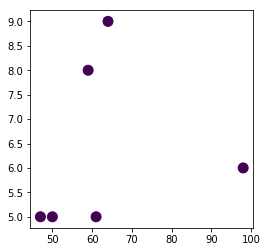

In [2]:
class Params:
    def __init__(self,Func,Y):
        if Func == 'Full':
            epochs = 1000
            reps = 50
            N_Max = 200
            T_Max = 48
            samp_size = 20
            Searches = 10
        else:
            epochs = 10
            reps = 5
            N_Max = 100
            N_min = 2
            T_Max = 10
            samp_size = 6
            Searches = 2
        N = np.array(np.random.rand(samp_size)*N_Max+N_min,dtype='int32')
        T = np.array(np.random.rand(samp_size)*T_Max,dtype='int32')
        d = {'N':N,'T':T}
        self.Runs = pd.DataFrame(data=d)
        self.params = {}
        self.params['T_Max'] = T_Max
        self.params['N_Max'] = N_Max
        self.params['reps'] = reps
        self.params['epochs'] = epochs
        self.params['Y'] = Y
        self.params['proc']=1
        self.params['Searches']=Searches

rpms = Params('Test','fch4')
# rpms = Params('Test',5,'ch4_flux')
Runs,params = rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
print(Runs)
print(params)
plt.figure(figsize = (4,4))
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

Using TensorFlow backend.


(1733, 1)
-3.14821163764
Finisehd Run  0
 Stats: 
N      64.000000
T       9.000000
MSE     0.858861
STD     0.112622
Name: 0, dtype: float64
(1737, 1)
-2.85700961289
Finisehd Run  1
 Stats: 
N      50.000000
T       5.000000
MSE     0.977017
STD     0.148688
Name: 1, dtype: float64
(1737, 1)
-3.8097837116
Finisehd Run  2
 Stats: 
N      47.000000
T       5.000000
MSE     1.030984
STD     0.158561
Name: 2, dtype: float64
(1734, 1)
-3.15995908565
Finisehd Run  3
 Stats: 
N      59.000000
T       8.000000
MSE     0.854141
STD     0.070095
Name: 3, dtype: float64
(1736, 1)
-1.33264752133
Finisehd Run  4
 Stats: 
N      98.000000
T       6.000000
MSE     0.825803
STD     0.203383
Name: 4, dtype: float64
(1737, 1)
-4.8475313952
Finisehd Run  5
 Stats: 
N      61.000000
T       5.000000
MSE     1.012251
STD     0.151902
Name: 5, dtype: float64
    N  T       MSE       STD
0  64  9  0.858861  0.112622
1  50  5  0.977017  0.148688
2  47  5  1.030984  0.158561
3  59  8  0.854141  0.070095
4  98

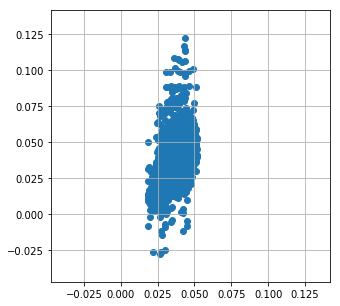

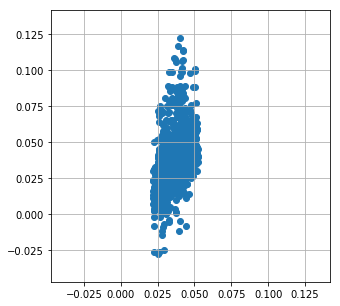

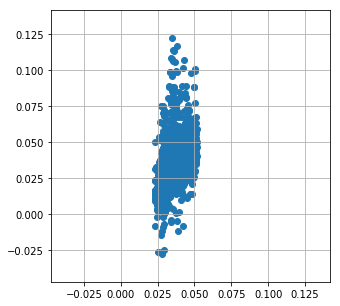

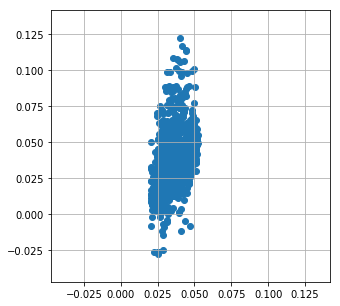

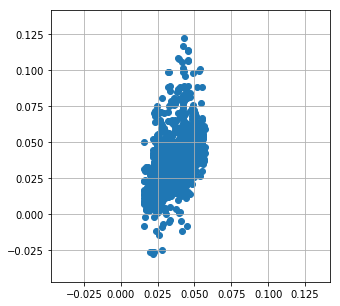

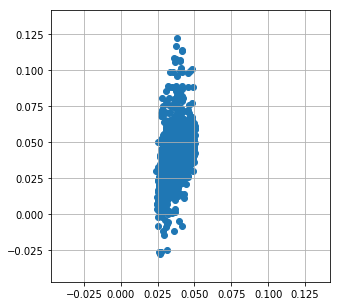

In [4]:
def TTV_Split(i,Memory,X,y,params):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(LSTM.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,y_val,i,X_fill = X,Memory=Memory))


Full = ['H','LE','Fco2','fco2','fch4','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table','Ts 2.5 cm',
         'Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']

Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Ts 2.5 cm','Ts 15 cm',
         'VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']


# Model = ['Water Table']

# Model = [' Active Layer','H']

Time = time.time()

Path = 'FilteredData2018-04-04.csv'


def RunReps(Model,Runs,params,pool = None):
    RST = RSTF.ReadStandardTimeFill(Path)#ReadStandardTime(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    RST.TimeShape(params['T'])
    y = RST.y_time*1.0
    X = RST.X_time*1.0
    MSE = []
    Y_fill = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params),range(params['reps']))):
            mse = results[0]
            y_fill = results[1]
            Y_fill.append(y_fill)
            MSE.append(mse)
    else:
        for i in range(params['reps']):
            results = TTV_Split(i,Memory,X,y,params)
            mse = results[0]
            MSE.append(mse)
            y_fill = results[1]
            Y_fill.append(y_fill)
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill).mean(axis=0)#.mean(axis=0)
    print(Y_fill.shape)
#     RST.Fill(Y_fill,'Fch4')
    y = RST.YScaled.inverse_transform(y)
    Y_fill = RST.YScaled.inverse_transform(Y_fill)
    
    plt.figure(figsize=(5,5))
    plt.scatter(Y_fill,y)
    yl = plt.ylim()
    plt.xlim(yl[0],yl[1])
    plt.grid()
#     print(metrics.r2_score(Y_fill,y))
    return(MSE)
    

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    

for i in Runs.index:
    params['T']=Runs['T'].iloc[i]
    params['N']=Runs['N'].iloc[i]
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehd Run ',str(i))
    print(' Stats: ')
    print(Runs.iloc[i])

print(Runs)
  
print(time.time()-Time)
        

No handles with labels found to put in legend.


(10, 100) (10, 100) (10, 100)


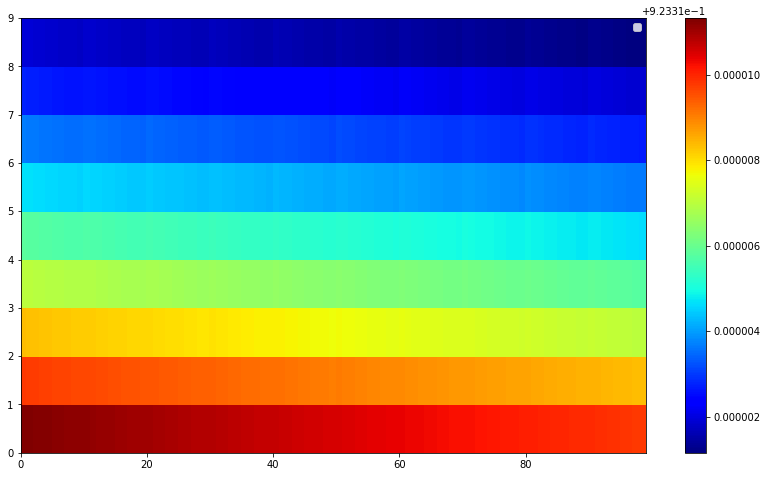

In [36]:
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (14, 8)
def probability_of_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return norm.cdf(gamma_x)


def expected_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return sigma_x * (gamma_x * norm.cdf(gamma_x) + norm.pdf(gamma_x))


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

kernel = Matern(length_scale = [1,1],length_scale_bounds="fixed")
kernel = ConstantKernel(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
+ WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=0,normalize_y=True)
gp.fit(Runs[['N','T']].values, Runs['MSE'].values)

N = [n for n in range(params['N_Max'])]
T = [t for t in range(params['T_Max'])]
A = [T[i] for j in range(len(N))for i in range(len(T))]
B = [N[j] for j in range(len(N))for i in range(len(T))]
T = np.asanyarray(A)
N = np.asanyarray(B)

# print(T)
# print(N)


X = np.zeros(shape=(T.shape[0],2))
X[:,0] = N
X[:,1] = T

Xi = np.arange(N.min(),N.max()+.1,1)
Yi = np.arange(T.min(),T.max()+.1,1)
xi,yi = np.meshgrid(Xi,Yi)

# print(xi.shape,yi.shape)

# print(X)

y_pred,sigma = gp.predict(X,return_std=True)
y_predi = y_pred.reshape(xi.shape[0],xi.shape[1])

print(yi.shape,xi.shape,y_predi.shape)

plt.figure()
# plt.imshow(y_pred)
plt.pcolor(xi,yi,y_predi,cmap=cm.jet)
plt.colorbar()
# plt.scatter(X[:,0],X[:,1],c=y_pred)#[:,0],X[:,1],y_pred)
plt.legend()
Runs2 = Runs.copy()

[ 97.14918738   3.92391241]
97 4
(1737, 1)
-4.8862906812
[ 0.97280482  1.06016304  0.84262521  1.27844543  0.8924588 ]
[ 98.95858162   7.91626995]
99 8
(1737, 1)
-4.56396776678
[ 0.96568016  1.05310779  0.842618    1.27846438  0.89245617]
        MSE   N       STD  T
0  1.030984  47  0.158561  5
1  0.977017  50  0.148688  5
2  0.854141  59  0.070095  8
3  1.012251  61  0.151902  5
4  0.858861  64  0.112622  9
5  1.009299  97  0.153487  4
6  0.825803  98  0.203383  6
7  1.006465  99  0.153406  8


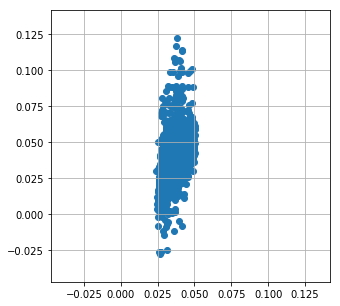

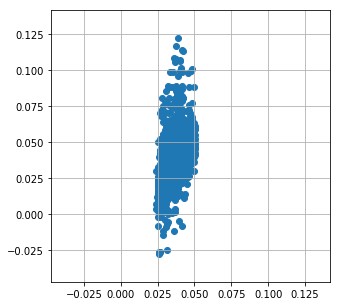

In [37]:
from scipy.optimize import minimize
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf

    for N in np.linspace(1,params['N_Max']):
        for T in np.linspace(0,params['T_Max']):
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
#                 print(np.min(yi),np.max(yi))
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray([N,T]).reshape(1,2)
            res = minimize(obj, x0, bounds=((1, params['N_Max']),(0,params['T_Max'])))

            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point

for i in range(params['Searches']):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
    
    next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
    print(next_x)
    N = int(np.round(next_x[0],0))
    T = int(np.round(next_x[1],0))
    o = 0
    while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
        print('Adjust!')
        o +=1
        N += int(o*np.cos(o*np.pi))
    print(N,T)
    d = {'N':N,'T':T,'MSE':0,'STD':0}
    idx = Runs.index[-1] + 1
    D2 = pd.DataFrame(data=d,index=[idx])
    Runs = Runs.append(D2)
    
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    print(MSE)
    Runs['MSE'][idx]=MSE.mean()
    Runs['STD'][idx]=MSE.std()
    
    Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    
print(Runs)

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

        MSE   N       STD  T
6  0.825803  98  0.203383  6


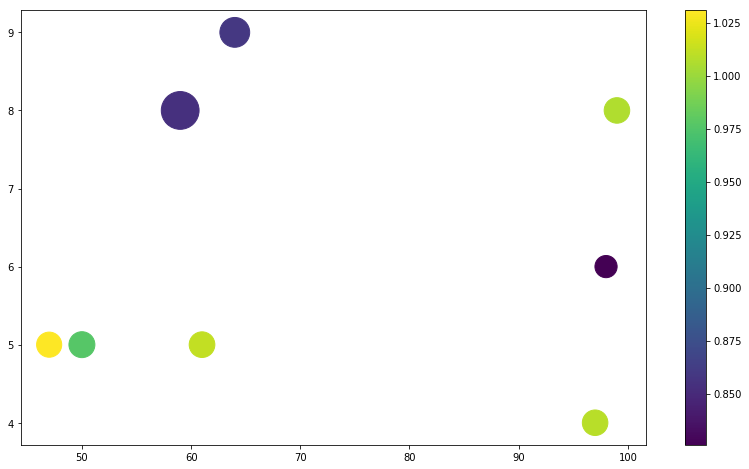

In [38]:
Best = Runs[Runs['MSE'] == Runs['MSE'].min()]
print(Best)
plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=1/Runs['STD']*100,c=Runs['MSE'])
plt.colorbar()
# plt.legend()

In [ ]:
def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor == None:
            Models.append(c)
        else:
            if set(factor).issubset(set(c)):
#             if factor in c:
                Models.append(c)
    return(Models)
# print(params)
params['T']=Best['T'].values[0]
params['N']=Best['N'].values[0]
params['proc']=1
FullModel = ['H','Wind Spd','air pressure','Ta']#,
#          'Rn','PPFD','Ts 2.5 cm','Ts 15 cm',
#          'VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']

Score= []
L = 1
Models = Combos(FullModel,1)

    
Models = Combos(FullModel,3,factor = ['H','air pressure'])


for i in range(1,len(FullModel)+1):
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
    for model in Models:
        Scores = []
        for model in Models:
            print(model)
            MSE = RunReps(model,Runs,params,pool)
            Score.append(MSE)
        Score = np.asanyarray(Score)
#         print(Score)
        print(np.where(Score == Score.min())[0][0])
        print(Models[np.where(Score == Score.min())[0][0]])
        Best = Models[np.where(Score == Score.min())[0][0]]
    print(Models)

['H']


AttributeError: 'list' object has no attribute 'min'